## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Галицкий Игорь Олегович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms


%matplotlib inline

/Users/igor/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(1)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
images_train = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

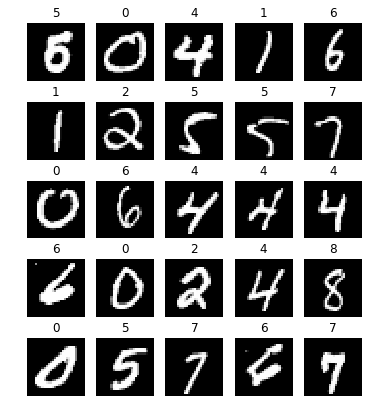

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0.0, std=1.0):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.0, std=0.1)

def forward_hook(self, input_, output):
        std = input_[0].std().data[0]
        print 'forward', std

def backward_hook(self, grad_input, grad_output):
        if grad_input[1] is not None:
            std = grad_input[1].std().data[0]
            print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def fully_connected(init_func, arc):
    layers = []
    for i in range(len(arc)-1):
        layer = nn.Linear(arc[i], arc[i+1])
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_func(layer)
        layers.append(layer)
        layers.append(nn.Tanh())
    layer = nn.Linear(500, 10)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    layers.append(layer)
    layers.append(nn.Tanh())
    return nn.Sequential(*layers)

In [8]:
model = fully_connected(init_layer, [28*28,500]*5)

In [9]:
n_objects = 32
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 81.8368148804
forward 0.998436152935
forward 0.816687703133
forward 0.819084644318
forward 0.77959394455
forward 0.813497304916
forward 0.777141928673
forward 0.81576526165
forward 0.778333961964
forward 0.817522466183
backward 0.00175055896398
backward 0.00187461473979
backward 0.00273959431797
backward 0.00304101174697
backward 0.00451916689053
backward 0.0049547040835
backward 0.0072302329354
backward 0.00791541580111
backward 0.0106745604426


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

# Xavier

In [10]:
##### YOUR CODE HERE #####
def init_layer_Xavier(layer):
    weight = layer.state_dict()['weight']
    n_out,n_in = weight.size()
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(6)/(np.sqrt(n_in  + n_out)),np.sqrt(6)/(np.sqrt(n_in  + n_out)))

In [11]:
model = fully_connected(init_layer_Xavier, [28*28,500]*5)

In [12]:
n_objects = 32
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 81.8368148804
forward 0.995974838734
forward 0.58789563179
forward 0.492781668901
forward 0.374601304531
forward 0.357266098261
forward 0.288118332624
forward 0.292538702488
forward 0.244674578309
forward 0.251155674458
backward 0.00182205147576
backward 0.00152899476234
backward 0.00160666566808
backward 0.00130320352037
backward 0.00132340472192
backward 0.00104204542004
backward 0.000995956361294
backward 0.000704227713868
backward 0.000559665611945


In [13]:
def init_layer_He(layer):
    weight = layer.state_dict()['weight']
    n_out,n_in = weight.size()
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.,std=np.sqrt(2.)/n_out)

In [14]:
model = fully_connected(init_layer_He, [28*28,500]*5)

In [15]:
n_objects = 32
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 81.8368148804
forward 0.936750292778
forward 0.0376567877829
forward 0.00299851107411
forward 0.000121260382002
forward 9.75641978584e-06
forward 3.94203141241e-07
forward 3.10933749859e-08
forward 1.23588161927e-09
forward 9.61232621277e-11
backward 0.00443448219448
backward 0.000280395935988
backward 1.41047530633e-05
backward 9.00159818684e-07
backward 4.54687594242e-08
backward 2.86218204693e-09
backward 1.4542086979e-10
backward 9.26207114477e-12
backward 4.59936505114e-13


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)


class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p
        self.n_in = input_dim
        self.n_out = output_dim

    def forward(self, x):
        self.mask = Variable(torch.Tensor(self.n_in,self.n_out).bernoulli_(self.p),requires_grad=False)
        batch_size = x.mm(self.weight*self.mask).size()[0]
        output = x.mm(self.weight*self.mask) + self.bias.repeat(batch_size,1) ##### YOUR CODE HERE #####
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

# 1 архитектура

In [54]:
network_dropout = nn.Sequential(
                            nn.Linear(784,200),
                            nn.Dropout(p=0.5),
                            nn.ReLU(),
                            nn.Linear(200,200),
                            nn.Dropout(p=0.5),
                            nn.ReLU(),
                            nn.Linear(200,10)                        
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_dropout.parameters(), lr=0.001)

In [55]:
import tqdm
batch_size = 100
n_epochs = 10

losses = [] 
for j in tqdm.tqdm(xrange(n_epochs)):
    for i in xrange(0,20000, batch_size):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_dropout(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


# 2 архитектура

In [56]:
network_dropconnect = nn.Sequential(
                            DropConnect(784,200),
                            nn.ReLU(),
                            DropConnect(200,200),
                            nn.ReLU(),
                            DropConnect(200,10),
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)

In [57]:
batch_size = 60
n_epochs = 10

losses_2 = [] 
for j in tqdm.tqdm(xrange(n_epochs)):
    for i in xrange(0,20000,batch_size):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_dropconnect(X)
        loss = loss_fn(activations, y)
        losses_2.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [01:22<00:00,  8.20s/it]


<i> 2.3 Сделайте выводы по третьей части </i>

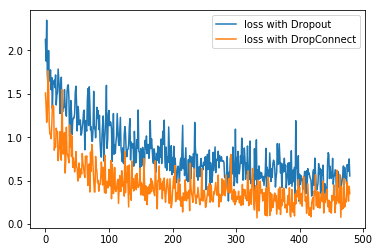

In [58]:
plt.plot(losses[20:500],label='loss with Dropout')
plt.plot(losses_2[20:500],label='loss with DropConnect')

plt.legend()

обучение хотябы происходит)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [35]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
        self.gamma = torch.nn.Parameter(torch.Tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self, x):
        batch_size,n_activations = x.size()
        output = self.gamma.repeat(batch_size,n_activations)*(x - x.mean(1).repeat(1,n_activations))/x.std(1).repeat(1,n_activations) + self.beta.repeat(batch_size,n_activations)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

# Архитектура 1

In [31]:
nn_1 = nn.Sequential(nn.Linear(784,200),
                     nn.ReLU(),
                     nn.BatchNorm1d(200),
                     nn.Linear(200,200),
                     nn.ReLU(),
                     nn.BatchNorm1d(200),
                     nn.Linear(200,10),
                     nn.BatchNorm1d(10),
                    )
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_1.parameters(), lr=0.001)

In [32]:
batch_size = 60
n_epochs = 10

losses = [] 
for j in tqdm.tqdm(xrange(n_epochs)):
    for i in xrange(0,20000,batch_size):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = nn_1(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


# Архитектура 2

In [37]:
nn_2 = nn.Sequential(nn.Linear(784,200),
                     nn.ReLU(),
                     LayerNormalization(),
                     nn.Linear(200,200),
                     nn.ReLU(),
                     LayerNormalization(),
                     nn.Linear(200,10),
                     LayerNormalization(),
                    )
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_2.parameters(), lr=0.001)

In [39]:
batch_size = 60
n_epochs = 10

losses = [] 
for j in tqdm.tqdm(xrange(n_epochs)):
    for i in xrange(0,20000,batch_size):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = nn_2(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/igor/anaconda/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:34: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.sub(b)
/Users/igor/anaconda/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:63: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.div(b)
/Users/igor/anaconda/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:48: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.mul(b)
100%|██████████| 10/10 [03:37<00:00, 21.72s/it]


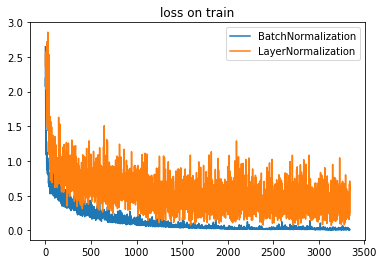

In [40]:
plt.plot(losses,label='BatchNormalization')
plt.plot(losses_2,label='LayerNormalization')
plt.title('loss on train')
plt.legend()

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: